# Calibration example

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import bootstrap
from radiocalibrationtoolkit import *

[INFO] LFmap: Import successful.


In [2]:
# This ensures Plotly output works in multiple places:
# plotly_mimetype: VS Code notebook UI
# notebook: "Jupyter: Export to HTML" command in VS Code
# See https://plotly.com/python/renderers/#multiple-renderers
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"

In [3]:
# some global plot settings
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 16
plt.rcParams["legend.fontsize"] = 14

plt.rcParams["xtick.major.width"] = 2
plt.rcParams["ytick.major.width"] = 2

plt.rcParams["xtick.major.size"] = 5
plt.rcParams["ytick.major.size"] = 5

plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

In [4]:
# for this example you need to create a mock power dataframe and simulated sidereal power dataset

## Calibrate with "true"

In [5]:
# in this case the recorded is the mock dataset
sky_map_model = "LFmap"

power_rec_DF = pd.read_csv(
    "./mock_power_datasets/mock_power_dataset-Salla_EW_"
    + sky_map_model
    + "_N10000_temp-10_50C_0.0additionalnoise_rounding-True.csv",
    index_col=0,
)

power_rec_DF.columns = power_rec_DF.columns.astype(float)

dir_path = "./simulated_power_datasets/"
df_files = [
    os.path.join(dir_path, i)
    for i in os.listdir(dir_path)
    if (i.endswith(".csv") & i.startswith("Salla_EW"))
]
file_path_2_true = [i for i in df_files if sky_map_model in i][0]
power_sim_DF = pd.read_csv(file_path_2_true, index_col=0)
power_sim_DF.columns = power_sim_DF.columns.astype(float)

antenna_type = "Salla_EW"
dir_path = "./simulated_power_datasets/"

concatenated_sim_df = concatenate_simulated_dfs(dir_path, antenna_type)

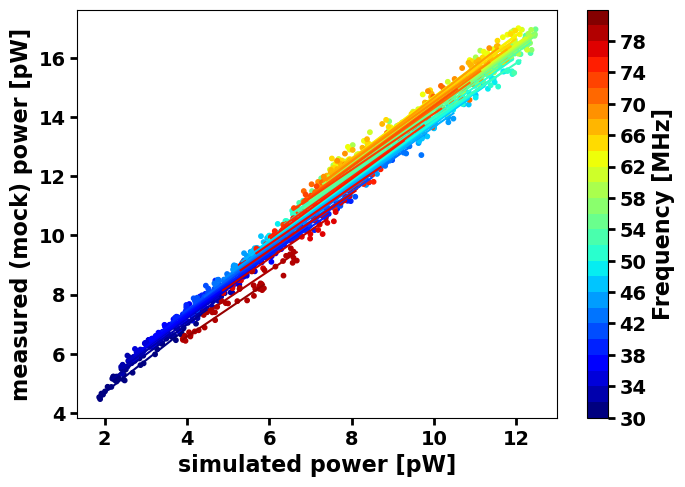

In [6]:
# fit each band and make a plot overview
cmapT = plt.get_cmap("jet")
bounds = np.arange(30, 83, 2)
norm = mpl.colors.BoundaryNorm(bounds, cmapT.N)

fig, ax = plt.subplots(figsize=(8, 6))

frequencies_MHz = power_sim_DF.columns.values
slopes = []
intercepts = []
for i, freq in enumerate(power_sim_DF.columns):
    c = [freq] * power_rec_DF.index.size
    x_arr = power_sim_DF.loc[:, freq].values
    y_arr = power_rec_DF.loc[:, freq].values
    cs = ax.scatter(x_arr, y_arr, s=10, c=c, norm=norm, cmap="jet")

    intercept, slope = robust_regression(x_arr, y_arr)
    intercepts.append(intercept)
    slopes.append(slope)
    x_new = np.linspace(np.min(x_arr), np.max(x_arr), 100)
    ax.plot(
        x_new,
        x_new * slope + intercept,
        color=cmapT((freq - np.min(bounds)) * (bounds[1] - bounds[0]) / 100),
    )

intercepts = np.asarray(intercepts) ** (1 / 2)
slopes = np.asarray(slopes) ** (1 / 2)

cbar = fig.colorbar(cs, ticks=np.arange(30, 81, 4), ax=ax)
cbar.set_label("Frequency [MHz]")
ax.set_xlabel("simulated power [pW]")
ax.set_ylabel("measured (mock) power [pW]")
fig.subplots_adjust(left=0.15, bottom=0.2)

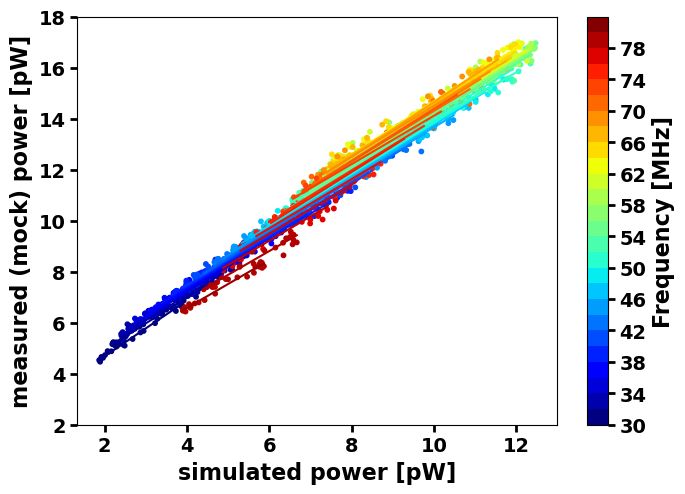

In [7]:
fig_data = pickle.dumps(fig)
fig2 = pickle.loads(fig_data)

# modify the axis limits of the copied figure
ax2 = fig2.axes
ax2[0].set_ylim(2, 18)
fig2

Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=0.0014095648643875913
Test2: p0.5=-0.0014095648643781544
Test3: p0.5+/-0.341=0.0007949805252250863
0.9977988994497249 0.9473736868434217 1.0491245622811407
Normalization test:  (0.9999997465698934, 8.367366209119815e-06)


(0.9977988994497249, 0.9473736868434217, 1.0500250125062531)

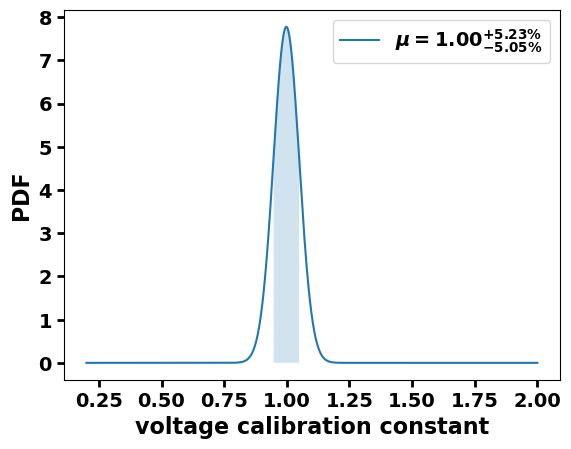

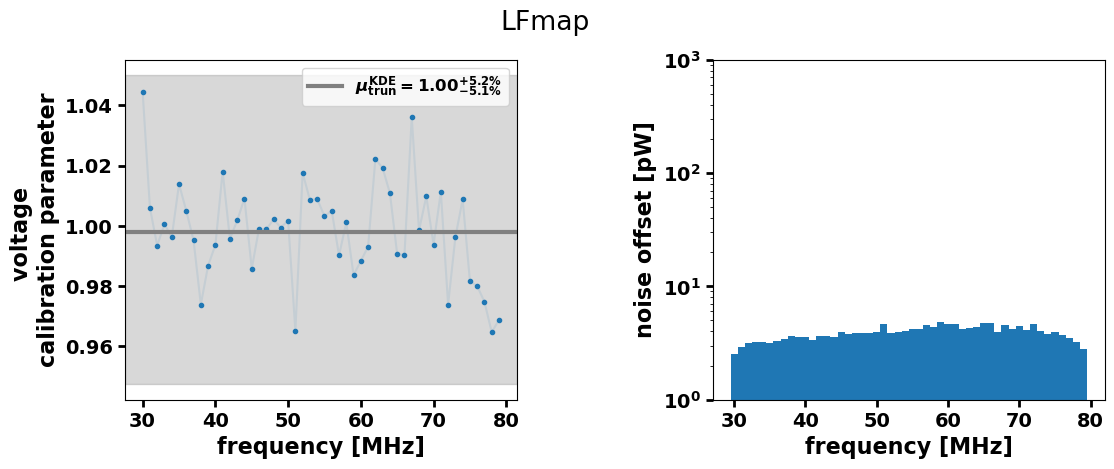

In [8]:
slopes_DF, intercepts_DF = get_fitted_voltage_calibration_params_and_noise_offsets(power_sim_DF, power_rec_DF)
get_and_plot_calibration_results(slopes_DF, intercepts_DF, title=sky_map_model, labels=None)

## Calibrate with all 'not true' simulated datasets

In [9]:
df_list = []
df_names = []
except_this = "Salla_EW_"+sky_map_model
for f in df_files:
    if except_this not in f:
        df = pd.read_csv(f, index_col=0)
        df.columns = df.columns.astype(float)
        df_list.append(df)
        df_names.append(Path(f).stem)

concatenated_sim_df = pd.concat(df_list, keys=df_names)
# check keys
[key for key in concatenated_sim_df.index.levels[0]]

['Salla_EW_GMOSS',
 'Salla_EW_ULSA',
 'Salla_EW_GSM08',
 'Salla_EW_Haslam',
 'Salla_EW_SSM',
 'Salla_EW_LFSS',
 'Salla_EW_GSM16']

Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=0.0016128016128159617
Test2: p0.5=-0.0016128016128064138
Test3: p0.5+/-0.341=-0.001372935735571068
1.0671335667833917 1.0059029514757378 1.1283641820910455
Normalization test:  (0.9999996936867219, 4.593107438354139e-06)


(1.0671335667833917, 1.0059029514757378, 1.1292646323161581)

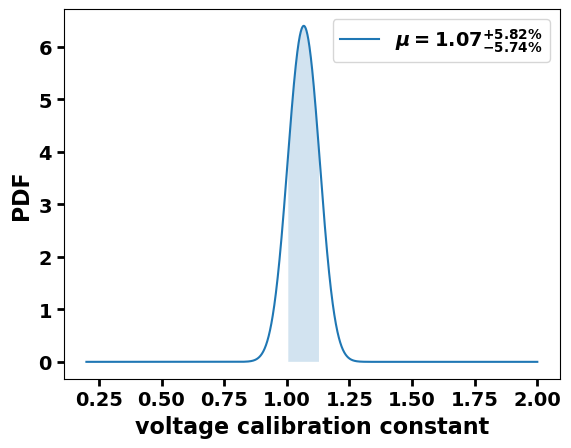

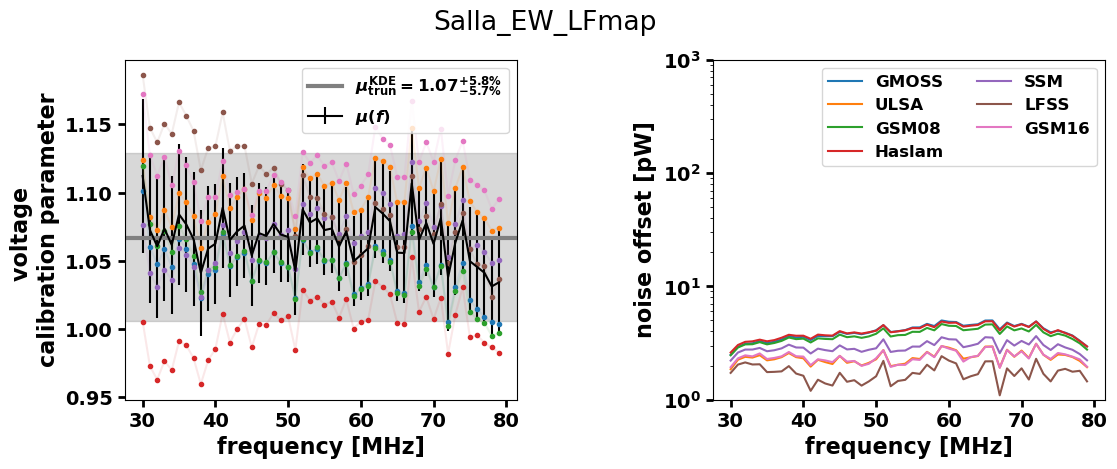

In [10]:
(
    slopes_DF,
    intercepts_DF,
) = get_fitted_voltage_cal_params_and_noise_offsets_from_concat_sim_dfs(
    concatenated_sim_df, power_rec_DF
)
get_and_plot_calibration_results(slopes_DF, intercepts_DF, title=except_this)

## Iteratively apply the previous procedure to all simulated datasets

In [11]:
# for this example you need to create a mock power dataframe and simulated sidereal power dataset

************************
GSM16
['Salla_EW_GMOSS', 'Salla_EW_ULSA', 'Salla_EW_GSM08', 'Salla_EW_Haslam', 'Salla_EW_LFmap', 'Salla_EW_SSM', 'Salla_EW_LFSS']


Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=0.0011128620629228259
Test2: p0.5=-0.0011128620629131114
Test3: p0.5+/-0.341=-2.294940812719304e-05
0.9401700850425212 0.8789394697348676 1.001400700350175
Normalization test:  (1.000001666178155, 3.5599836161498855e-06)
************************
************************
LFSS
['Salla_EW_GMOSS', 'Salla_EW_ULSA', 'Salla_EW_GSM08', 'Salla_EW_Haslam', 'Salla_EW_LFmap', 'Salla_EW_SSM', 'Salla_EW_GSM16']


Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=-0.0001646157927197578
Test2: p0.5=0.0001646157927293057
Test3: p0.5+/-0.341=0.0003869591688764329
0.9509754877438721 0.8888444222111056 1.015807903951976
Normalization test:  (0.9999996199571539, 5.3261019541753255e-06)
************************
************************
GSM08
['Salla_EW_GMOSS', 'Salla_EW_ULSA', 'Salla_EW_Haslam', 'Salla_EW_LFmap', 'Salla_EW_SSM', 'Salla_EW_LFSS', 'Salla_EW_GSM16']


Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=0.002476926830653925
Test2: p0.5=-0.002476926830644377
Test3: p0.5+/-0.341=-1.67675874277462e-05
1.014007003501751 0.9482741370685344 1.0779389694847423
Normalization test:  (0.9999999975661396, 7.110808530162103e-06)
************************
************************
Haslam
['Salla_EW_GMOSS', 'Salla_EW_ULSA', 'Salla_EW_GSM08', 'Salla_EW_LFmap', 'Salla_EW_SSM', 'Salla_EW_LFSS', 'Salla_EW_GSM16']


Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=0.0005809929283888682
Test2: p0.5=-0.0005809929283790427
Test3: p0.5+/-0.341=0.00022858946283499382
1.0590295147573787 0.9950975487743872 1.1229614807403703
Normalization test:  (1.0000010953113656, 5.8539345150653045e-06)
************************
************************
LFmap
['Salla_EW_GMOSS', 'Salla_EW_ULSA', 'Salla_EW_GSM08', 'Salla_EW_Haslam', 'Salla_EW_SSM', 'Salla_EW_LFSS', 'Salla_EW_GSM16']


Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=0.0016128016128159617
Test2: p0.5=-0.0016128016128064138
Test3: p0.5+/-0.341=-0.001372935735571068
1.0671335667833917 1.0059029514757378 1.1283641820910455
Normalization test:  (0.9999996936867219, 4.593107438354139e-06)
************************
************************
SSM
['Salla_EW_GMOSS', 'Salla_EW_ULSA', 'Salla_EW_GSM08', 'Salla_EW_Haslam', 'Salla_EW_LFmap', 'Salla_EW_LFSS', 'Salla_EW_GSM16']


Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=0.0016649643807146175
Test2: p0.5=-0.0016649643807049586
Test3: p0.5+/-0.341=0.0014481908282403255
0.9806903451725864 0.9140570285142571 1.0491245622811407
Normalization test:  (0.999999596649851, 6.784258453692367e-06)
************************
************************
GMOSS
['Salla_EW_ULSA', 'Salla_EW_GSM08', 'Salla_EW_Haslam', 'Salla_EW_LFmap', 'Salla_EW_SSM', 'Salla_EW_LFSS', 'Salla_EW_GSM16']


Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=0.0007653411186733239
Test2: p0.5=-0.0007653411186636649
Test3: p0.5+/-0.341=0.0015077400453994416
1.015807903951976 0.9500750375187594 1.08064032016008
Normalization test:  (1.0000000490418244, 6.952903049657667e-06)
************************
************************
ULSA
['Salla_EW_GMOSS', 'Salla_EW_GSM08', 'Salla_EW_Haslam', 'Salla_EW_LFmap', 'Salla_EW_SSM', 'Salla_EW_LFSS', 'Salla_EW_GSM16']


Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=-0.00159864499075546
Test2: p0.5=0.001598644990765008
Test3: p0.5+/-0.341=-0.0011347548600298962
0.9509754877438721 0.8897448724362182 1.0149074537268634
Normalization test:  (0.9999996040561989, 5.575372865980736e-06)
************************


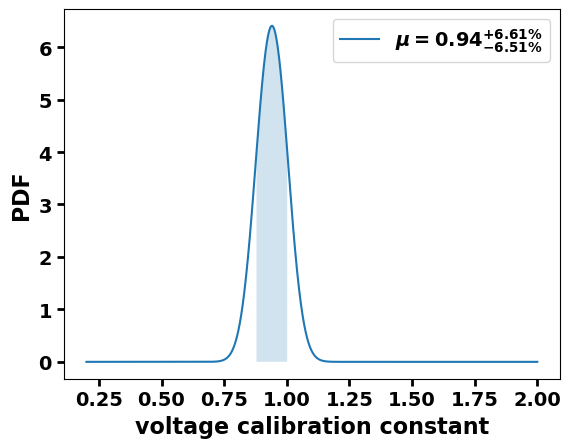

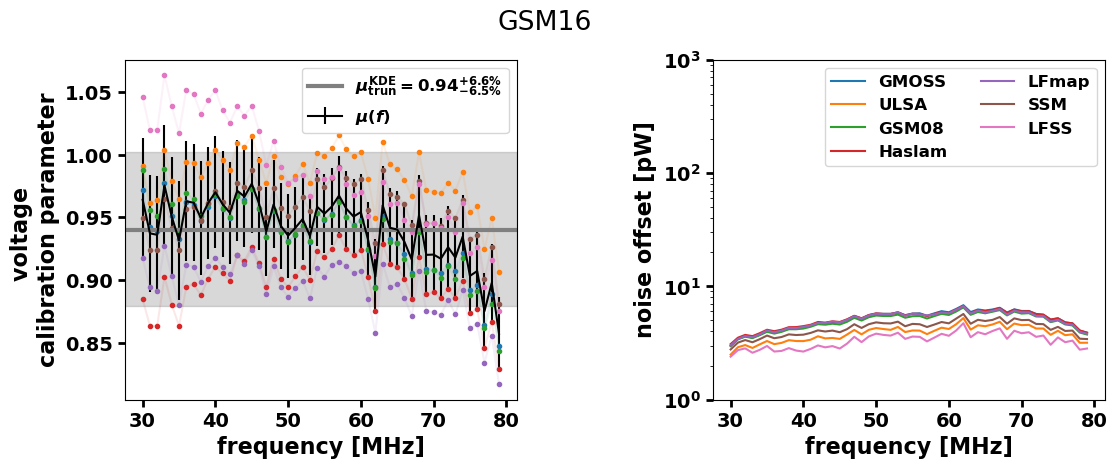

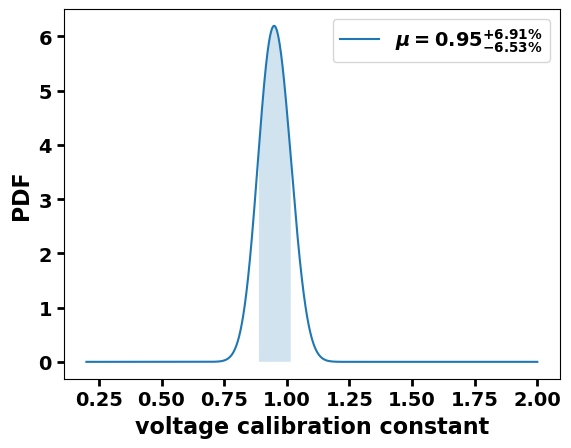

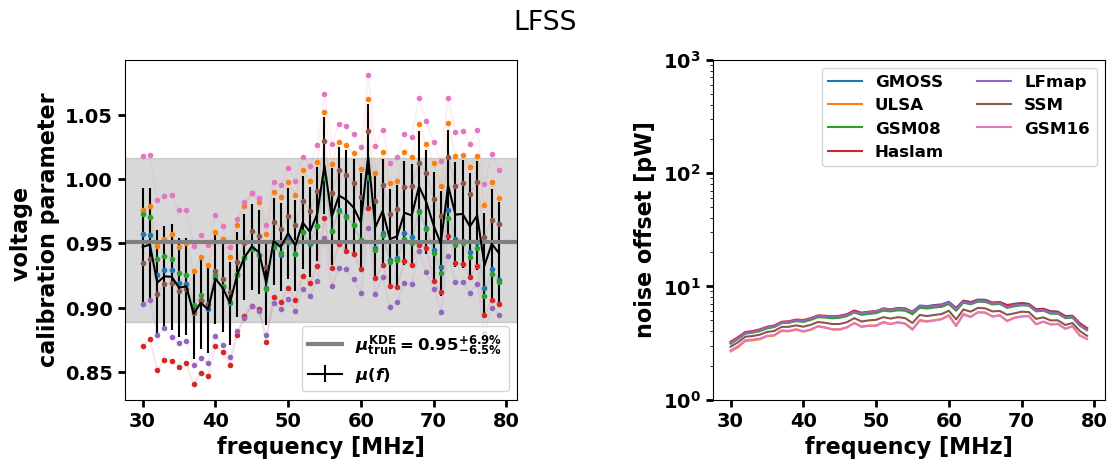

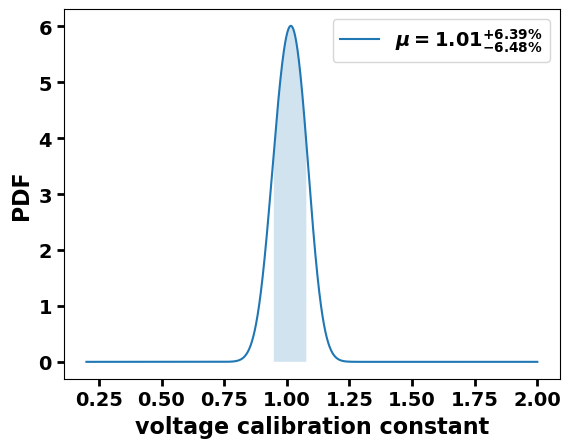

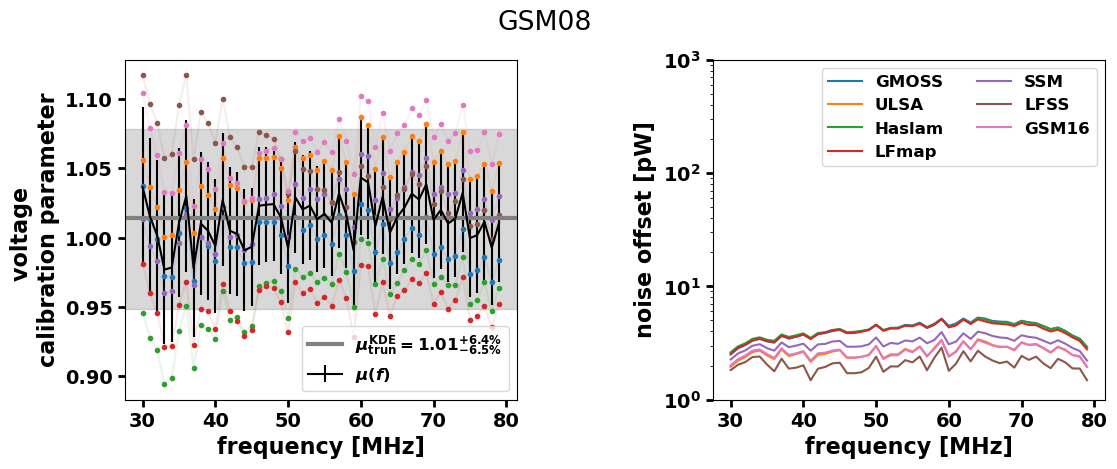

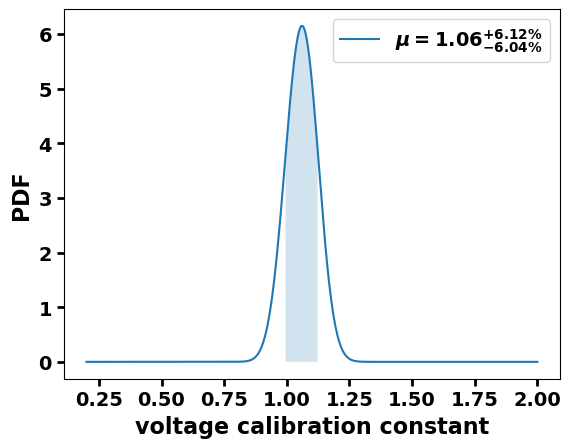

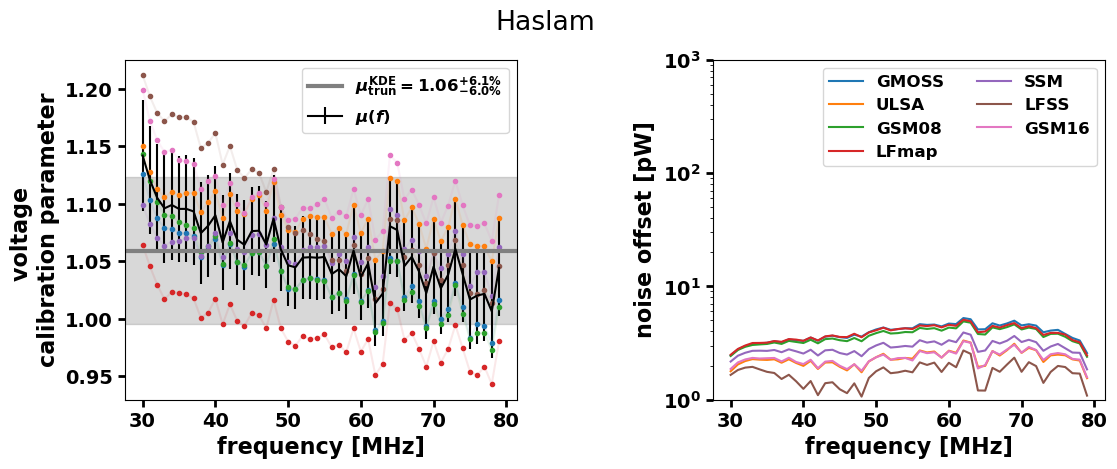

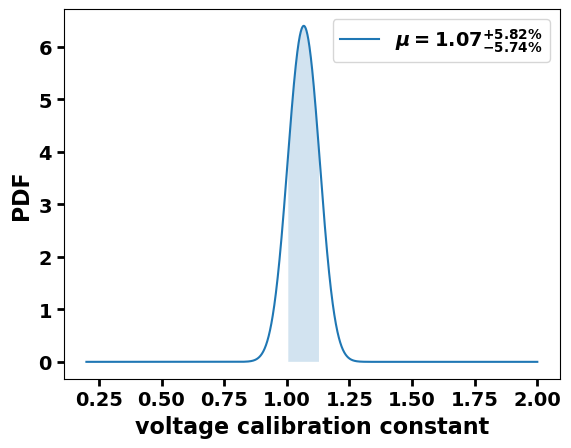

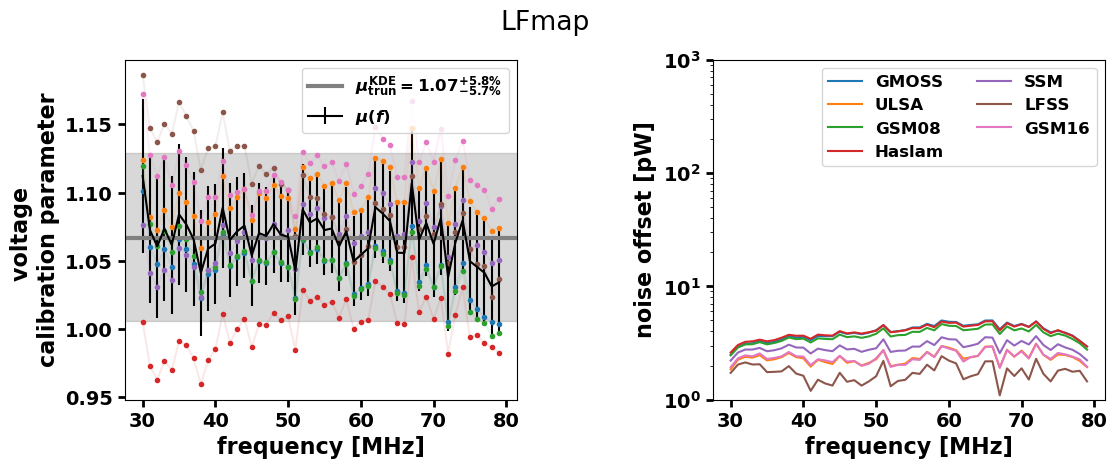

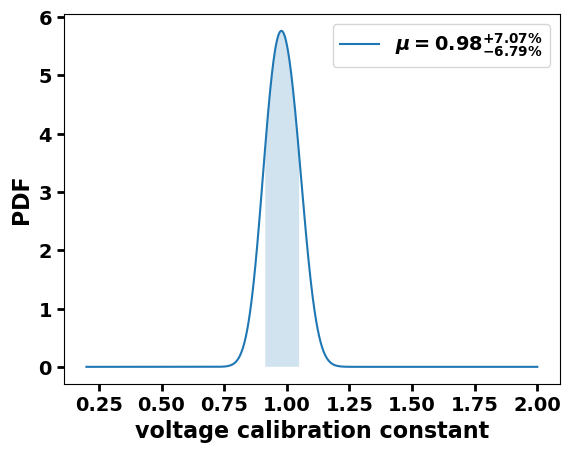

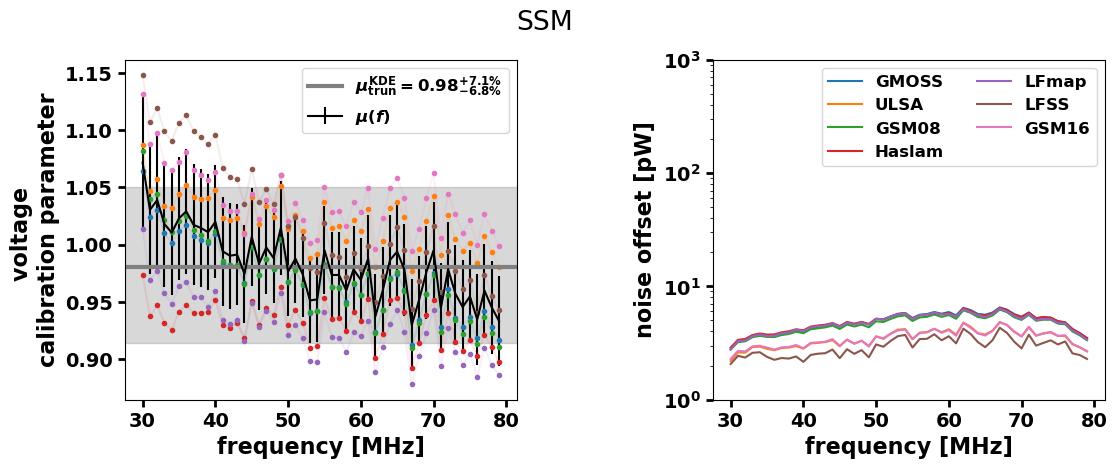

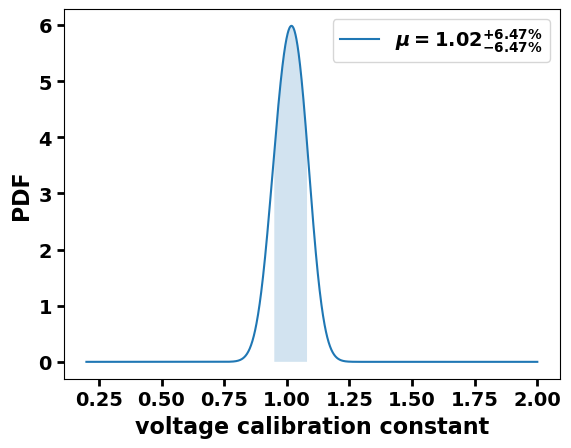

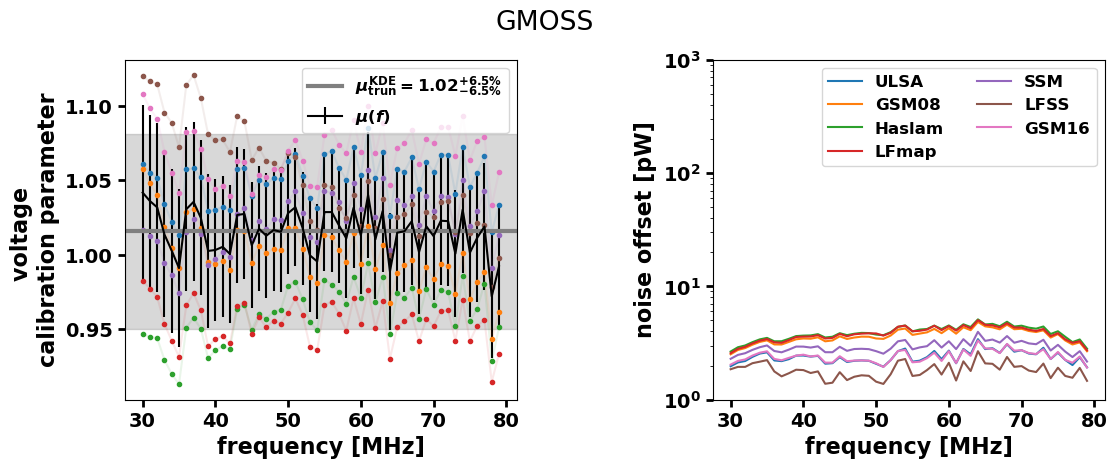

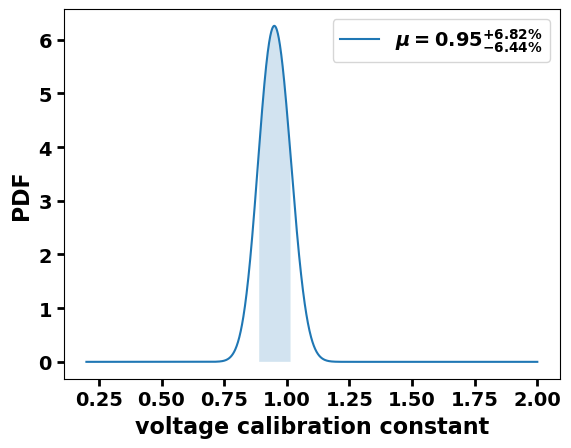

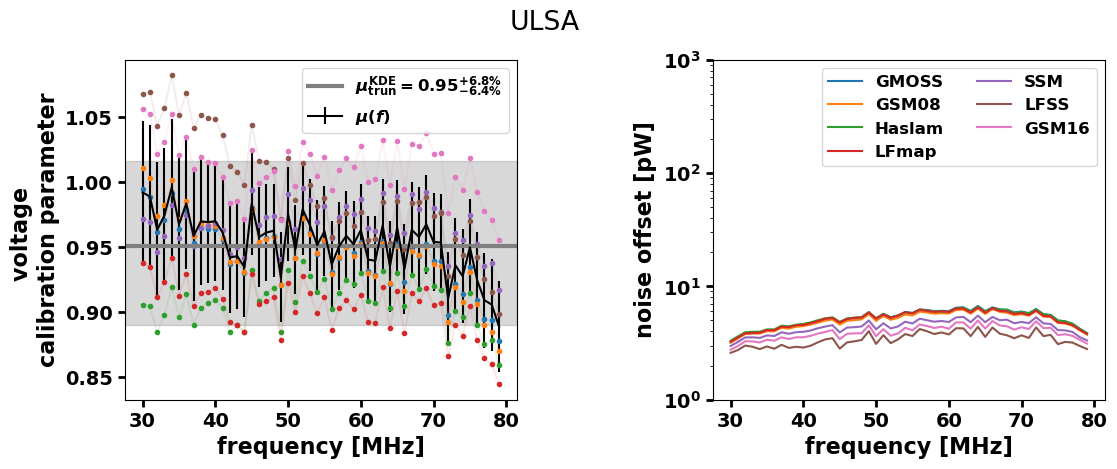

In [12]:
galactic_models = [
    "GSM16",
    "LFSS",
    "GSM08",
    "Haslam",
    "LFmap",
    "SSM",
    "GMOSS",
    "ULSA",
]

all_freq_dep_cal_params_dict = {}
all_freq_dep_noise_dict = {}
central_stats_dict = {}
for gmodel in galactic_models:
    print("************************")
    print(gmodel)
    df_list = []
    df_names = []
    measured_label = "Salla_EW_" + gmodel
    for f in df_files:
        if measured_label not in f:
            df = pd.read_csv(f, index_col=0)
            df.columns = df.columns.astype(float)
            df_list.append(df)
            df_names.append(Path(f).stem)

    print(df_names)
    concatenated_sim_df = pd.concat(df_list, keys=df_names)
    power_rec_DF = pd.read_csv(
        "./mock_power_datasets/mock_power_dataset-"
        + measured_label
        + "_N10000_temp-10_50C_0.0additionalnoise_rounding-True.csv",
        index_col=0,
    )
    power_rec_DF.columns = power_rec_DF.columns.astype(float)
    (
        slopes_DF,
        intercepts_DF,
    ) = get_fitted_voltage_cal_params_and_noise_offsets_from_concat_sim_dfs(
        concatenated_sim_df, power_rec_DF
    )
    all_freq_dep_cal_params_dict[gmodel], all_freq_dep_noise_dict[gmodel] = (
        slopes_DF,
        intercepts_DF,
    )
    central_stats_dict[gmodel] = get_and_plot_calibration_results(
        slopes_DF, intercepts_DF, title=gmodel
    )
    print("************************")

In [13]:
all_slopes_df = pd.concat(all_freq_dep_cal_params_dict)
all_intercepts_df = pd.concat(all_freq_dep_noise_dict)
central_stats_DF = pd.DataFrame(central_stats_dict, index=["mu", "err_low", "err_high"]).T

Truncating data to 5, 95 percentils
Iteration number: 1 out of max 9 iterations
Test1: p0.5=0.002013900060338747
Test2: p0.5=-0.002013900060329643
Test3: p0.5+/-0.341=0.0022066061212077104
0.9968984492246125 0.9212606303151576 1.0743371685842922
Normalization test:  (0.9999997046308042, 8.117105066936797e-06)


(0.9968984492246125, 0.9212606303151576, 1.0752376188094048)

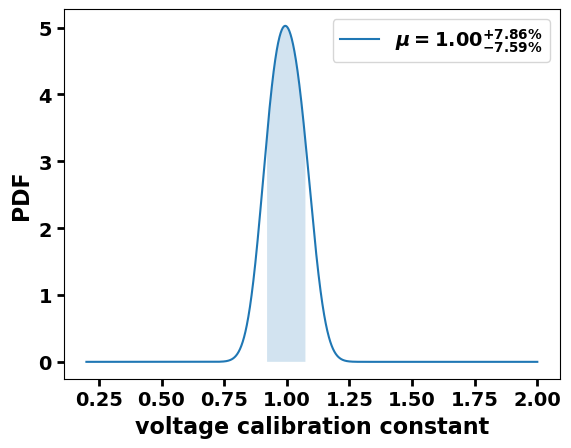

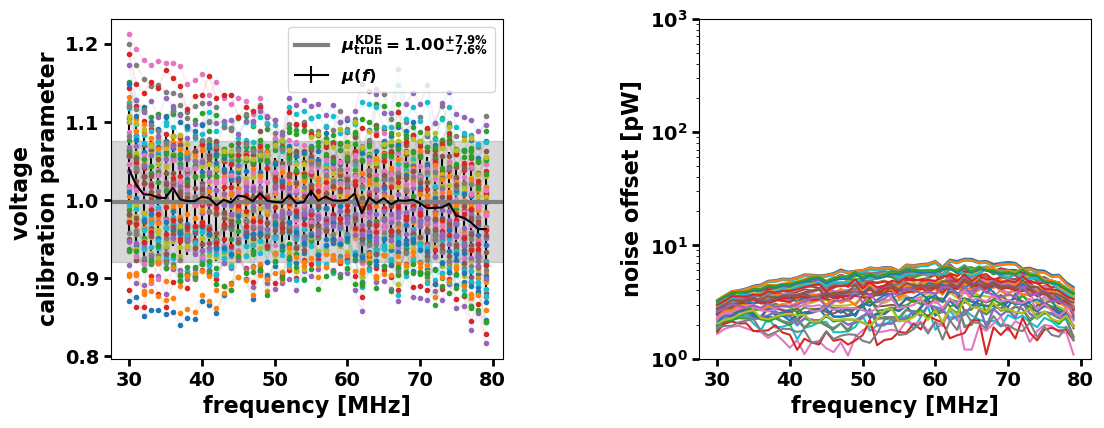

In [14]:
get_and_plot_calibration_results(all_slopes_df, all_intercepts_df, title="", labels=None)

Min and Max observed bias:
0.9401700850425212 1.0671335667833917


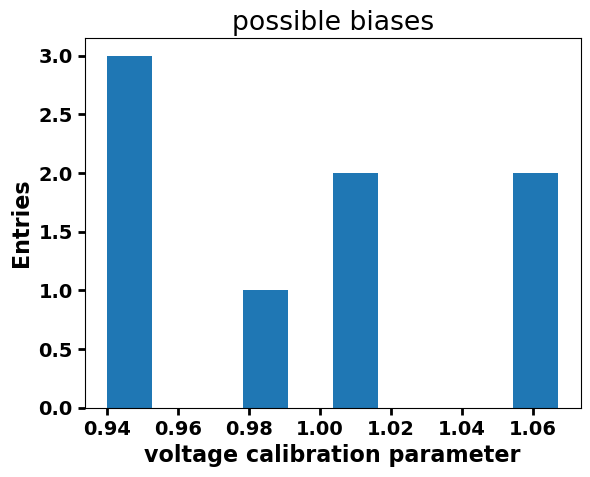

In [15]:
fig, ax = plt.subplots()

ax.set_title("possible biases")
ax.hist(central_stats_DF.mu.values)
ax.set_xlabel("voltage calibration parameter")
ax.set_ylabel("Entries")

print("Min and Max observed bias:")
print(np.min(central_stats_DF.mu.values), np.max(central_stats_DF.mu.values))

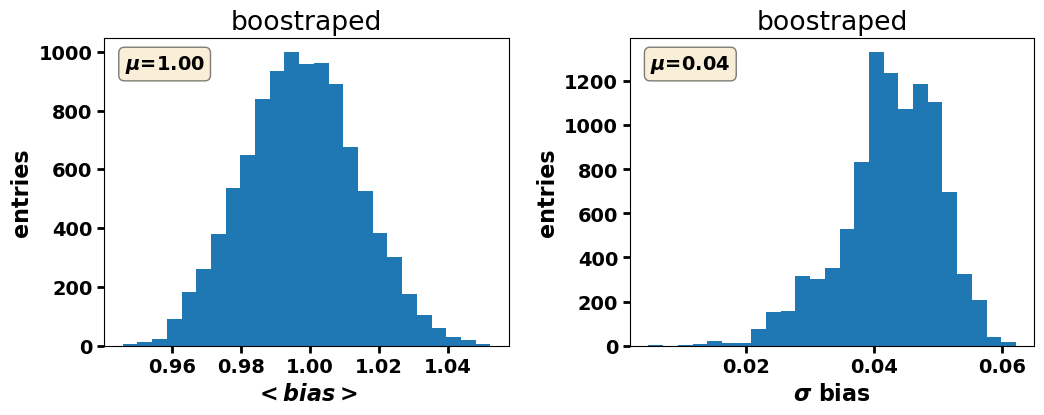

In [16]:
data = (central_stats_DF.mu.values,)  # samples must be in a sequence

props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
res = bootstrap(data, np.mean, confidence_level=0.9)
bvalues = res.bootstrap_distribution
ax[0].hist(bvalues, bins=25)
ax[0].set_title("boostraped")
ax[0].set_xlabel(r"$<bias>$")
ax[0].text(
    0.05,
    0.95,
    "$\mu$={:.2f}".format(np.mean(bvalues)),
    transform=ax[0].transAxes,
    fontsize=14,
    verticalalignment="top",
    bbox=props,
)
ax[0].set_ylabel("entries")

ax[1].set_title("boostraped")
res = bootstrap(data, np.std, confidence_level=0.9)
bvalues = res.bootstrap_distribution
ax[1].hist(bvalues, bins=25)
ax[1].set_xlabel("$\sigma$ bias")
ax[1].text(
    0.05,
    0.95,
    "$\mu$={:.2f}".format(np.mean(bvalues)),
    transform=ax[1].transAxes,
    fontsize=14,
    verticalalignment="top",
    bbox=props,
)
ax[1].set_ylabel("entries")
fig.subplots_adjust(wspace=0.3)